In [1]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [46]:
data_import = pd.read_csv('/Users/sitanshurupani/Data Science Coursework/Sem 4/GQP - National Parks/DataSpell Project/Data/Daily_attendance.csv')

In [47]:
all_years_test = data_import
all_years_test.set_index('Full_Date', inplace=True)

In [48]:
all_years_test.index = pd.to_datetime(all_years_test.index)
ds = all_years_test.index.to_series()
all_years_test['YEAR'] = ds.dt.year
all_years_test['MONTH'] = ds.dt.month
all_years_test['DAY_OF_WEEK'] = ds.dt.dayofweek
all_years_test['DAY'] = ds.dt.day

In [49]:
all_years_test.drop(columns=['snow_1h', 'temp_max', 'temp_min','YEAR', 'wind_gust', 'pressure'], inplace=True)
all_years_test["federal_holiday_flag"] = all_years_test["federal_holiday_flag"].astype(int)
all_years_test["school_holiday_flag"] = all_years_test["school_holiday_flag"].astype(int)

In [50]:
all_years_test.isna().sum()

value                   0
temp                    0
pressure                0
humidity                0
wind_speed              0
wind_gust               3
rain_1h                 0
federal_holiday_flag    0
school_holiday_flag     0
MONTH                   0
DAY_OF_WEEK             0
DAY                     0
dtype: int64

In [51]:
all_years_test['wind_gust'].fillna((all_years_test['wind_gust'].mean()), inplace=True)

In [62]:
df_standard_scale = StandardScaler()
# x_standard = df_standard_scale.fit_transform(all_years_test.loc[:, all_years_test.columns != 'value'], copy=True)
x_standard = pd.DataFrame(df_standard_scale.fit_transform(all_years_test), columns=all_years_test.columns)

In [90]:
x_standard.drop(columns=['value','federal_holiday_flag','school_holiday_flag'],inplace=True)
x_standard['value'] = all_years_test['value'].values
x_standard['federal_holiday_flag'] = all_years_test['federal_holiday_flag'].values
x_standard['school_holiday_flag'] = all_years_test['school_holiday_flag'].values
x_standard.index = all_years_test.index

In [91]:
mask = np.random.rand(len(x_standard)) < 0.8
df_train = x_standard[mask]
df_test = x_standard[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=369
Testing data set length=91


In [92]:
expr = """value ~ DAY  + DAY_OF_WEEK + MONTH + temp + pressure + humidity + wind_speed + wind_gust + rain_1h + federal_holiday_flag + school_holiday_flag"""

In [93]:
# X_train, X_test, y_train, y_test = train_test_split(all_years_test.loc[:, all_years_test.columns != 'value'], all_years_test['value'], test_size =0.2, random_state = 42)

In [94]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [95]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [96]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  value   No. Observations:                  369
Model:                            GLM   Df Residuals:                      357
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -30290.
Date:                Sun, 17 Apr 2022   Deviance:                       57302.
Time:                        18:08:35   Pearson chi2:                 5.65e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                7.0642 

In [97]:
print(poisson_training_results.mu)

[ 774.2523713   501.89779704  532.3464486   533.79829093  749.60530293
  648.41225503  602.97496264  625.60011609  783.77237596  502.23610784
  712.33728551  950.46611304  521.35051502  519.73907381  705.7009344
  666.49484031  737.48165713  575.36140777  761.41972959  836.89902661
  771.5443328   944.29126929  743.92931556  994.43760581  555.09974138
  734.82580226  873.80111438 1020.4363493   898.03547456 1030.91026496
  901.75825786  890.33366221 1246.02191632 1054.40286705  559.47722239
 1177.16449673  702.67523386  693.5705847  1184.60062151 1364.90313572
 1193.71450393 1166.14191822 1038.87395803  822.3216097   580.90013236
 1438.35095712 1707.45032644 1239.67327303 1153.92847956  726.1791397
  932.46607429 1176.57070954 1181.67636809 1218.51813346 1197.00055115
 1781.4224819  1441.11385964 1703.59739376 1502.16699466 1652.7376837
 1313.22904716 1069.06471134 1439.56941466 1587.07871548 1529.05337717
 1535.50486994 1529.04425621 1935.08083444 2055.12076303 1553.76246413
 1244.120

In [98]:
mu_glm = poisson_training_results.mu

In [99]:
df_train['Value_LAMBDA'] = mu_glm

/var/folders/90/98s1yvbs2zq9h146qcbc3t_h0000gn/T/ipykernel_49359/2113704252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Value_LAMBDA'] = mu_glm


In [100]:
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['value'] - x['Value_LAMBDA'])**2 - x['Value_LAMBDA']) / x['Value_LAMBDA'], axis=1)

/var/folders/90/98s1yvbs2zq9h146qcbc3t_h0000gn/T/ipykernel_49359/1666380816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['value'] - x['Value_LAMBDA'])**2 - x['Value_LAMBDA']) / x['Value_LAMBDA'], axis=1)


In [101]:
ols_expr = """AUX_OLS_DEP ~ Value_LAMBDA - 1"""

In [102]:
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

In [103]:
print(aux_olsr_results.params)

Value_LAMBDA    0.102114
dtype: float64


In [104]:
aux_olsr_results.tvalues

Value_LAMBDA    10.292224
dtype: float64

In [105]:
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [106]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  value   No. Observations:                  369
Model:                            GLM   Df Residuals:                      357
Model Family:        NegativeBinomial   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2798.4
Date:                Sun, 17 Apr 2022   Deviance:                       550.15
Time:                        18:08:46   Pearson chi2:                     492.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                7.0840 

In [107]:
nb2_predictions = nb2_training_results.get_prediction(X_test)

In [108]:
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

                   mean     mean_se  mean_ci_lower  mean_ci_upper
Full_Date                                                        
2019-05-13   606.635077   33.655104     544.132009     676.317714
2019-05-19   736.017055   40.617208     660.562929     820.090079
2019-05-24   658.959476   36.989814     590.306603     735.596704
2019-05-28   731.906663   43.514823     651.400838     822.362104
2019-06-03   783.428909   45.270932     699.539716     877.378140
...                 ...         ...            ...            ...
2021-10-19  1402.330606  106.010146    1209.214224    1626.288453
2021-10-21  1546.681137   75.269332    1405.973106    1701.471050
2021-10-22  1715.497157   97.562482    1534.550200    1917.780530
2021-10-28  1607.823929  131.308202    1370.005557    1886.925037
2021-10-30  1593.307360  100.014211    1408.861847    1801.900129

[91 rows x 4 columns]


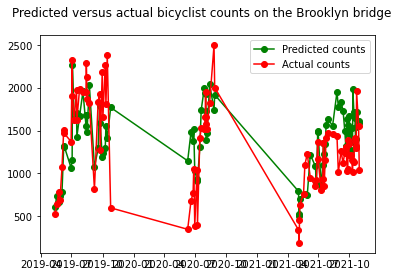

In [109]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

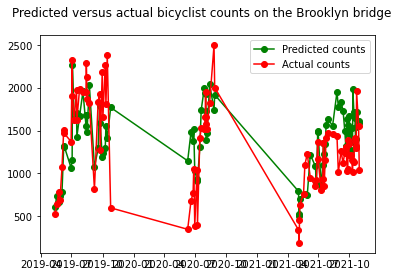

In [110]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

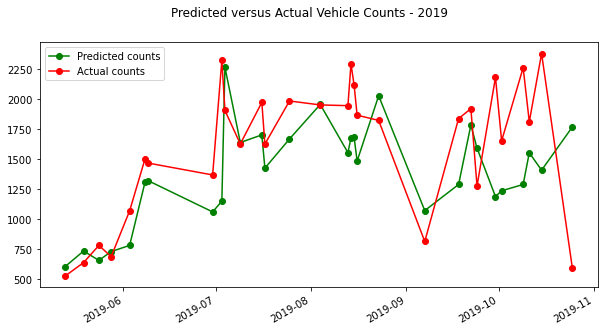

In [111]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
predicted_counts = predicted_counts[predicted_counts.index.year==2019]
actual_counts = actual_counts[actual_counts.index.year==2019]
fig = plt.figure(figsize=(10,5))
fig.suptitle('Predicted versus Actual Vehicle Counts - 2019')
predicted, = plt.plot(predicted_counts.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts.index, actual_counts, 'ro-', label='Actual counts')
fig.autofmt_xdate()
plt.legend(handles=[predicted, actual])
plt.show()

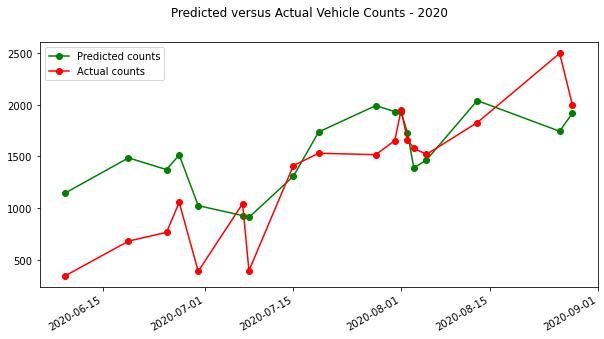

In [112]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
predicted_counts = predicted_counts[predicted_counts.index.year==2020]
actual_counts = actual_counts[actual_counts.index.year==2020]
fig = plt.figure(figsize=(10,5))
fig.suptitle('Predicted versus Actual Vehicle Counts - 2020')
predicted, = plt.plot(predicted_counts.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts.index, actual_counts, 'ro-', label='Actual counts')
fig.autofmt_xdate()
plt.legend(handles=[predicted, actual])
plt.show()

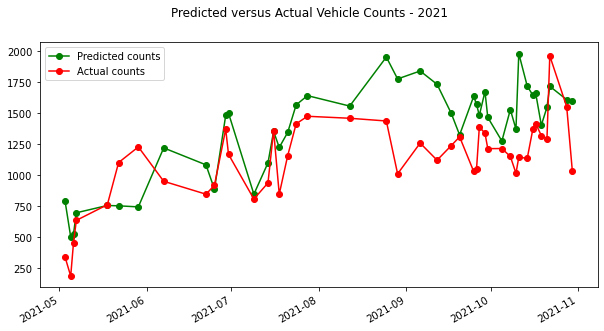

In [113]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
predicted_counts = predicted_counts[predicted_counts.index.year==2021]
actual_counts = actual_counts[actual_counts.index.year==2021]
fig = plt.figure(figsize=(10,5))
fig.suptitle('Predicted versus Actual Vehicle Counts - 2021')
predicted, = plt.plot(predicted_counts.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts.index, actual_counts, 'ro-', label='Actual counts')
fig.autofmt_xdate()
plt.legend(handles=[predicted, actual])
plt.show()

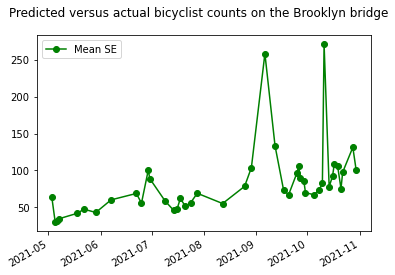

In [114]:
predicted_mean_se=predictions_summary_frame['mean_se']
predicted_mean_se = predicted_mean_se[predicted_mean_se.index.year==2021]
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(predicted_mean_se.index, predicted_mean_se, 'go-', label='Mean SE')
fig.autofmt_xdate()
plt.legend(handles=[predicted])
plt.show()

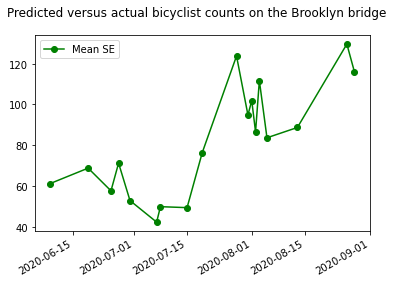

In [115]:
predicted_mean_se=predictions_summary_frame['mean_se']
predicted_mean_se = predicted_mean_se[predicted_mean_se.index.year==2020]
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(predicted_mean_se.index, predicted_mean_se, 'go-', label='Mean SE')
fig.autofmt_xdate()
plt.legend(handles=[predicted])
plt.show()

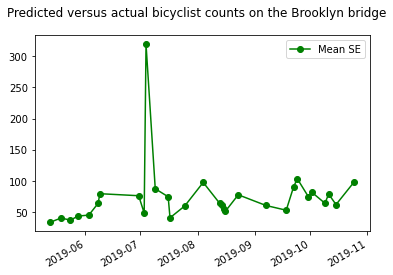

In [116]:
predicted_mean_se=predictions_summary_frame['mean_se']
predicted_mean_se = predicted_mean_se[predicted_mean_se.index.year==2019]
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(predicted_mean_se.index, predicted_mean_se, 'go-', label='Mean SE')
fig.autofmt_xdate()
plt.legend(handles=[predicted])
plt.show()

In [117]:
from statsmodels.tools.eval_measures import rmse
rmse = rmse(y_test, predictions_summary_frame['mean'])

<Figure size 432x288 with 0 Axes>

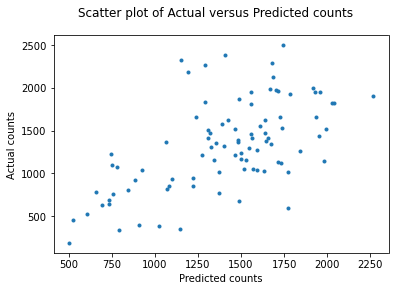

In [118]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

In [120]:
np.sqrt(((y_test['value'] - predictions_summary_frame['mean']) ** 2).mean())

431.89812432471547